# Load Data

In [3]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from math import ceil, floor, log
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
import PIL
import pathlib
from PIL import Image
from glob import glob

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report

from keras.layers import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications import DenseNet121, ResNet50V2, InceptionV3
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import Sequence

if 'checkpoint' not in os.listdir('./'):
    os.mkdir('./checkpoint')

In [ ]:
input_path = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
test_images_dir = input_path + 'stage_2_test/'
train_images_dir = input_path + 'stage_2_train/'

In [2]:
path = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_000012eaf.dcm'
img = pydicom.dcmread(path)
img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.337944818669776895705763408052798539612
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_000012eaf
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_f15c0eee'
(0020, 000d) Study Instance UID                  UI: ID_30ea2b02d4
(0020, 000e) Series Instance UID                 UI: ID_0ab5820b2a
(0020, 0010) Study ID                            SH: '

# Data Pre-Processing

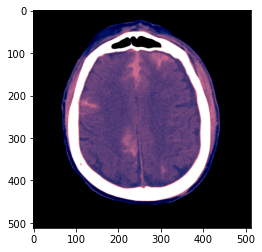

In [5]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

dicom = pydicom.dcmread(train_images_dir + 'ID_5c8b5d701' + '.dcm')
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);


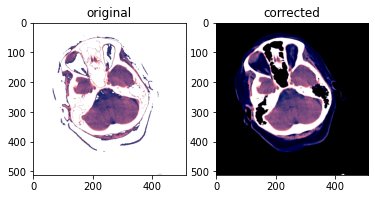

In [6]:
def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + "ID_036db39b7" + ".dcm")

fig, ax = plt.subplots(1, 2)

ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(window_testing(dicom, window_with_correction), cmap=plt.cm.bone);
ax[1].set_title("corrected");

In [54]:
df = pd.read_csv('../input/rsna-csv-files/RSNA_DATA/good_slices.csv',index_col = 'Unnamed: 0')

In [55]:
def get_partition_labels(df):
    partition = dict()
    labels = dict()
    for i in trange(len(df)):
        id_ = df.Image[i]
        label = df.iloc[i,1:7].to_numpy(dtype = 'int32')
        labels[id_] = label
        
    df = df.sample(frac = 0.1)
    training = df.sample(frac = 0.8)
    
    validation = df.drop(training.index, axis = 0)
    test = validation.sample(frac = 0.5)
    validation = validation.drop(test.index, axis = 0) 
    
    partition['train'] = list(training.Image)
    partition['validation'] = list(validation.Image)
    partition['test'] = list(test.Image)
    return partition,labels

In [56]:
partition,labels = get_partition_labels(df)

100%|██████████| 315084/315084 [01:22<00:00, 3797.85it/s]


In [57]:
len(partition['train'])
values_view = labels.values()
value_iterator = iter(values_view)
first_value = next(value_iterator)
print(next(iter(labels)))
print(first_value)


values_view2 = partition.values()
value_iterator2 = iter(values_view)
first_value2 = next(value_iterator)
print(next(iter(partition['train'])))
print(first_value2)

ID_896989c9d
[0 0 0 0 0 0]
ID_823feb706
[0 0 0 0 0 0]


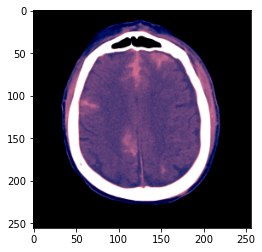

In [58]:
def _read(path, desired_size):
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    return img
 
plt.imshow(
    _read(train_images_dir+'ID_5c8b5d701'+'.dcm', (256, 256,3)), cmap=plt.cm.bone
);

In [60]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.true_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)
        
        self.true_labels.append(y)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        X = np.empty((self.batch_size, *self.dim)) 
        y = np.empty((self.batch_size,6), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            image_dir = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'
            X[i,] = _read(image_dir+ID+'.dcm',self.dim)
            y[i] = self.labels[ID]

        return X,y

# Pretrained CNN Models

choose and run one of the model

In [ ]:
params = {'dim':(224,224,3),
         'batch_size':64,
         'n_classes':6,
         'n_channels':0,
         'shuffle':True}

In [ ]:
# ResNet50
def create_resnet_model(num_classes=6, trainable_base=False):
    base_model = ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=params['dim'],
        pooling='max'
    )
    
    base_model.trainable = trainable_base
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(30, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [ ]:
# VGG16
def create_vgg16_model(num_classes=6, trainable_base=False):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=params['dim'],
        pooling='avg'
    )
    
    base_model.trainable = trainable_base
    
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [ ]:
# Inception V#
def create_inception_model(num_classes=6, trainable_base=False):
    inception_params = {'dim': (299, 299, 3)}
    
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=inception_params['dim'],
        pooling='avg'
    )
    
    base_model.trainable = trainable_base
    
    model = Sequential([
        base_model,
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [ ]:
# Xception
def create_xception_model(num_classes=6, trainable_base=False):
    xception_params = {'dim': (299, 299, 3)}
    
    base_model = Xception(
        include_top=False,
        weights="imagenet",
        input_shape=xception_params['dim'],
        pooling='avg'
    )
    
    base_model.trainable = trainable_base
    
    model = Sequential([
        base_model,
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [ ]:
# DenseNet121 
def create_densenet_model(num_classes=6, trainable_base=False):
    base_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=params['dim'],
        pooling='avg'
    )
    
    base_model.trainable = trainable_base
    
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model

# Training

In [ ]:
# add callbacks
callbacks = [
    ModelCheckpoint(filepath='./checkpoint', monitor = 'val_weighted_loss' ,save_best_only=True,verbose = 3),
    ReduceLROnPlateau(monitor= 'val_weighted_loss', factor=0.1, patience= 3, verbose=1,mode='auto', min_delta=0.0001)]

In [ ]:
# data generator
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])

In [61]:
# train model

history = model.fit(training_generator,
        validation_data=validation_generator, 
        epochs=100, 
        callbacks=callbacks)

Epoch 1/10
393/393 [==============================] - 786s 2s/step - loss: 0.3849 - binary_accuracy: 0.9025 - val_loss: 0.3007 - val_binary_accuracy: 0.9214
Epoch 2/10
393/393 [==============================] - 592s 2s/step - loss: 0.1693 - binary_accuracy: 0.9376 - val_loss: 0.1990 - val_binary_accuracy: 0.9333
Epoch 3/10
393/393 [==============================] - 555s 1s/step - loss: 0.1538 - binary_accuracy: 0.9428 - val_loss: 0.1921 - val_binary_accuracy: 0.9391
Epoch 4/10
393/393 [==============================] - 539s 1s/step - loss: 0.1347 - binary_accuracy: 0.9500 - val_loss: 0.1998 - val_binary_accuracy: 0.9233
Epoch 5/10
393/393 [==============================] - 541s 1s/step - loss: 0.1279 - binary_accuracy: 0.9519 - val_loss: 0.1891 - val_binary_accuracy: 0.9283
Epoch 6/10
393/393 [==============================] - 543s 1s/step - loss: 0.1179 - binary_accuracy: 0.9560 - val_loss: 0.1571 - val_binary_accuracy: 0.9429
Epoch 7/10
393/393 [==============================] - 549s

# Evaluation

In [62]:
# training graph
acc = history.history['binary_accuracy']
val_acc =  history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

NameError: name 'history' is not defined

In [63]:
from tensorflow.keras import backend as K

def weighted_log_loss(y_true, y_pred):
    class_weights =  tf.Variable([2., 1., 1., 1., 1., 1.])
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

def weighted_log_loss_V2(y_true, y_pred):
    class_weights =  tf.constant([2., 1., 1., 1., 1., 1.])
    
    eps = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)

    out = -(         y_true  * tf.math.log(      y_pred) * class_weights
            + (1.0 - y_true) * tf.math.log(1.0 - y_pred) * class_weights)
    
    return tf.reduce_mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):

    class_weights = tf.constant([2., 1., 1., 1., 1., 1.])
    eps = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * tf.math.log(      y_pred)
            + (1.0 - y_true) * tf.math.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    return tf.reduce_mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()



In [65]:
# evaluation
params_test = {'dim':(224,224,3),
         'batch_size':64,
         'n_classes':6,
         'n_channels':0,
         'shuffle':False}

test_generator = DataGenerator(partition['test'], labels, **params_test)
test_pred = model.predict(test_generator,verbose=1)
predicted_classes = tf.argmax(test_pred, axis=1)

49/49 [==============================] - 38s 771ms/step


In [ ]:
print(len(partition['test']))
prediction_with_treshold = []

treshold = 0.1

for sample in test_pred:
    prediction_with_treshold.append([1 if i>=treshold else 0 for i in sample ] )
prediction_with_treshold = np.array(prediction_with_treshold)
print(len(prediction_with_treshold))

print(type(test_generator.true_labels[10]))
total_list = np.concatenate(test_generator.true_labels)
total_list = total_list[:-1, :]
print(len(total_list))

accuracy_score(total_list, prediction_with_treshold)
print(multilabel_confusion_matrix(total_list, prediction_with_treshold))
print(classification_report(total_list, prediction_with_treshold, target_names = ['Any', 'Epidural', 'Intraparenychemal','Intraventricular','Subarachnoid','Subdural']))

In [ ]:
print("Test Accuracy: ", model.evaluate(test_generator))

# Fine Tuning

In [ ]:
# unfreeze the base model
base_model = model.layers[0]
base_model.trainable = True

# freeze all layers except the last 'unfreeze_layers'
for layer in base_model.layers[:-unfreeze_layers]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
history_tuned = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        verbose=1
    )